# Graph-Parametrized Equivariant 1-form Representation Learning

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [2]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import networkx as nx
import torch_geometric

# Generate some graph data for examples

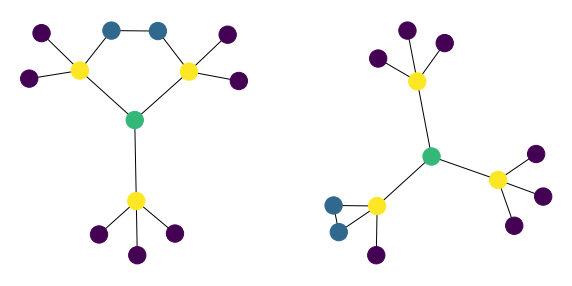

In [4]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)

# draw a tree graph with 10 nodes
H = nx.balanced_tree(3, 2)

# add an edge between 7 and 8
H.add_edge(7, 8)

# calculate the spring layout for H
Gpos = nx.spring_layout(G)
Hpos = nx.spring_layout(H)

# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))
plt.subplot(1, 2, 2)
nx.draw(H, pos=Hpos, with_labels=False, font_weight='bold', node_color=list(dict(H.degree()).values()))

## Turning graphs into tensors

In [5]:
# a function for turning a path into a chain
def nxgraph_to_chain(graph, features):
    """ 
    A function for turning a graph into a chain
    Inputs: 
        graph: an nx_graph
        features: a torch tensor of features for each node of size (m,n) where m is the number of nodes and n is the feature dimension

    outputs:
        ch: a torch tensor of shape (r,2,n) where r is the number of edges and n is the feature dimension
    """

    # get node features
    node_features = features

    # get edges
    edge_index = torch.tensor(list(graph.edges))

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [6]:
Gpos = torch.tensor(list(Gpos.values()))
Hpos = torch.tensor(list(Hpos.values()))

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/983239627.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  Gpos = torch.tensor(list(Gpos.values()))


In [7]:
# extract the degree sequence from the graph
degree_sequence = list(dict(G.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

one_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0]])

In [8]:
# extract the degree sequence from the graph
degree_sequence = list(dict(H.degree()).values())

degree_sequence = torch.tensor(degree_sequence).float()

# one hot encode the degree sequence
Hone_hot_degree_sequence = torch.nn.functional.one_hot(degree_sequence.to(torch.int64))

Hone_hot_degree_sequence

tensor([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]])

By convention, we will always use $Z$ to denote matrix the positional, equivariant node features, and $H$ to denote the matrix of 'scalar' or non-equivariant node features. If the position of the nodes is in $\mathbb{R}^n$ and the scalar features are in $\mathbb{R}^m$, the respective matrices are in $\mathbb{R}^{s_0 \times n}$ and $\mathbb{R}^{s_0 \times m}$, where $s_0$ is the number of nodes in the graph.

In [9]:
# make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
Gdata = {'graph': G, 'Z': Gpos.float(), 'H': one_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(G, Gpos), 'H_chains' : nxgraph_to_chain(G, one_hot_degree_sequence).float()}

# make a dictionary containing: the graph H, the node positions Hpos, and the one hot degree sequence, the chains
Hdata = {'graph': H, 'Z': Hpos.float(), 'H': Hone_hot_degree_sequence.float(), 'Z_chains': nxgraph_to_chain(H, Hpos), 'H_chains' : nxgraph_to_chain(H, Hone_hot_degree_sequence).float()}

We will also use the coboundary of the positional and scalar features. These matrices are $dZ \in \mathbb{R}^{s_1 \times n}$ and $dH \in \mathbb{R}^{s_1 \times m}$, where $s_1$ is the number of edges in the graph. These encode the tangent vector along each edge wrt these respective coordinate types.

In [10]:
Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])
Hdata['dZ'] = (Hdata['Z_chains'][:,1,:] - Hdata['Z_chains'][:,0,:])
Hdata['dH'] = (Hdata['H_chains'][:,1,:] - Hdata['H_chains'][:,0,:])

In [11]:
Gdata['Z'].T.float() @ Gdata['H'].float()

tensor([[ 0.0000,  0.0152, -0.0081, -0.0035, -0.0037],
        [ 0.0000, -1.1020,  1.1668, -0.0460, -0.0188]])

(-1.0, 1.0)

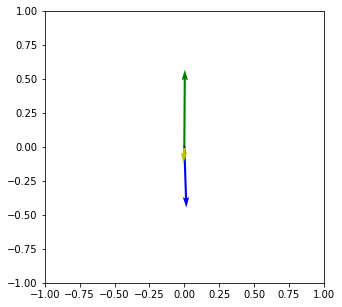

In [12]:
vec = Gdata['dZ'].T @ Gdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

(-1.0, 1.0)

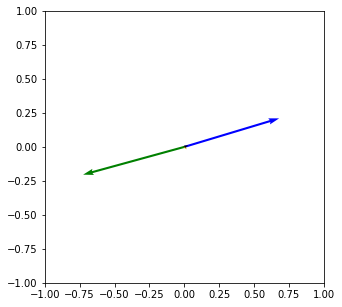

In [13]:
vec = Hdata['dZ'].T @ Hdata['dH']

# plot the columns of vec as vectors starting from the origin
plt.figure(figsize=(5,5))

# plot the columns of vec as vectors starting from the origin

plt.quiver(0, 0, vec[0,0], vec[1,0], angles='xy', scale_units='xy', scale=1, color='r')

plt.quiver(0, 0, vec[0,1], vec[1,1], angles='xy', scale_units='xy', scale=1, color='b')

plt.quiver(0, 0, vec[0,2], vec[1,2], angles='xy', scale_units='xy', scale=1, color='g')

plt.quiver(0, 0, vec[0,3], vec[1,3], angles='xy', scale_units='xy', scale=1, color='y')

plt.quiver(0, 0, vec[0,4], vec[1,4], angles='xy', scale_units='xy', scale=1, color='k')

# zoom out
plt.xlim(-1, 1)

plt.ylim(-1, 1)

# plot the columns of vec as vectors starting from the origin

In [14]:
Gdata['Z'].shape

Gdata['Z'].T @ Gdata['H']

base = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']),axis=1)

base.shape

torch.Size([2, 10])

In [15]:
# build a random tensor of 7x2 
X = torch.rand(7,2)

# shape is batch x (2*non-eq dim)
(X @ base).shape

torch.Size([7, 10])

In [16]:
dimH = 5
dimZ = 2

num_vf = 3

# generate a torch sequential neural network with two hidden layers
model = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [17]:
model(X @ base).shape

out = model(X @ base)

In [18]:
out.shape

torch.Size([7, 33])

In [19]:
print(X.shape)
print(base.shape)

# for each row of X, concatenate the transpose of the rwo iwth the base
c = torch.cat((X.T, base), axis=1)


Y = X.unsqueeze(-1)

print(Y.shape)


# stack the bases along the batch dimension
bases = torch.stack([base] * X.shape[0])

print(bases.shape)

# create a list with X.shape[0] copies of base without using a for loop

full_bases = torch.cat((Y,bases),axis=-1)

full_bases.shape

torch.Size([7, 2])
torch.Size([2, 10])
torch.Size([7, 2, 1])
torch.Size([7, 2, 10])


torch.Size([7, 2, 11])

In [20]:
out = out.view(-1, num_vf, 1+2*dimH)

# switch 1st and 2nd dimensions
out = out.permute(0,2,1)

out.shape

torch.Size([7, 11, 3])

In [21]:
full_bases.shape

torch.Size([7, 2, 11])

In [22]:
# this is the output containing the vector field values of each batch
final = torch.matmul(full_bases, out)

print("final.shape: " , final.shape)

# we wrap it up into the correct format for integration matrix layer
finalwrap = final.view(-1, dimZ * num_vf)

finalwrap.shape

final.shape:  torch.Size([7, 2, 3])


torch.Size([7, 6])

In [23]:
# create a forward pass
def fwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, 2*h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # apply the model to the invariant summary
    out = model(X @ base)

    # calculate dim h
    dimh = base.shape[1] // 2

    # calculate num_vf
    nvf = int(out.shape[1] / (1+2*dimh))


    # stack the bases along the batch dimension
    bases = torch.stack([base] * X.shape[0])

    # 
    Y = X.unsqueeze(-1)

    full_bases = torch.cat((Y,bases),axis=-1)

    out = out.view(-1, nvf, 1+2*dimh)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [24]:
fwd(X,model,base).shape

torch.Size([7, 2, 3])

In [25]:
base.shape

# times the base on the right by a 2d rotation matrix of angle 
def rot(base, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R.float() @ base 

# times the base on the right by a 2d rotation matrix of angle

Rbase = rot(base, np.pi)

Rbase.shape

torch.Size([2, 10])

In [26]:
inp = torch.tensor([[0.1,0.5]]).float()

fwd(inp,model,base)

tensor([[[-0.0055,  0.0025, -0.0067],
         [ 0.0144,  0.1732, -0.1023]]], grad_fn=<UnsafeViewBackward0>)

In [27]:
def simple_vf_plot(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,10)
    y = np.linspace(-radius,radius,10)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((10,10))
    V = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

In [28]:
# times the base on the right by a 2d rotation matrix of angle 
def rot(base, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return R.float() @ base 

def rot2(pos, angle):
    R = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return pos.float() @ R.T.float()


We check that the rotations of the base indeed induce a corresponding rotation of the vector field.

Text(0.5, 0.98, 'Vector field for different rotations of the base')

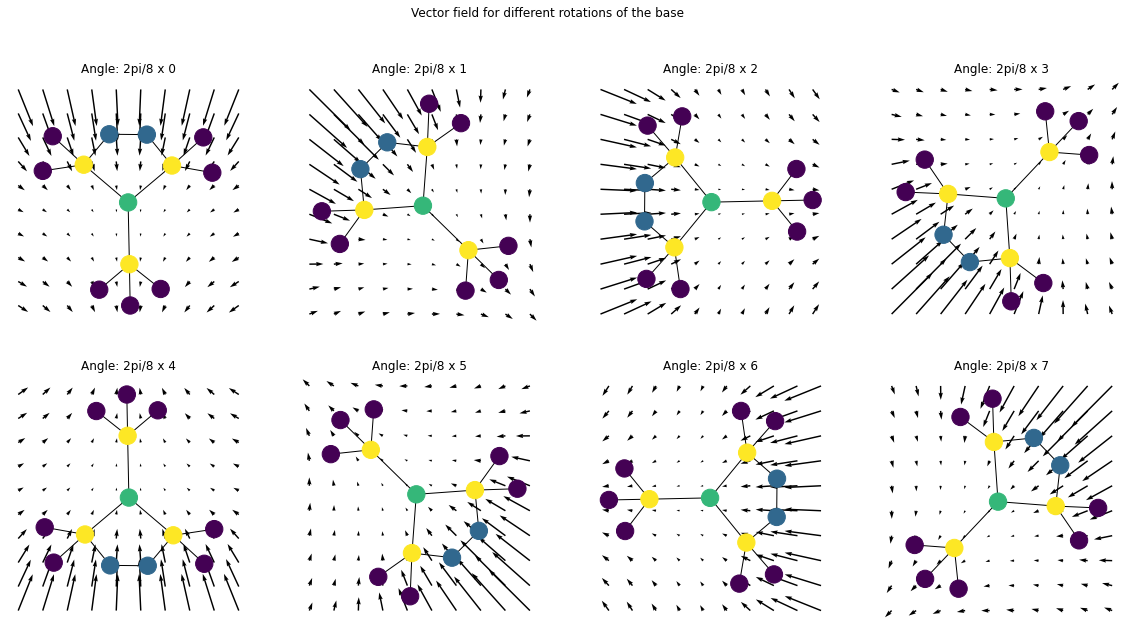

In [31]:
angles = np.arange(0,2*np.pi,2*np.pi/8)

comp = 2

fig, ax = plt.subplots(2,4,figsize=(20,10))

for i in range(8):
    simple_vf_plot(model, rot(base,angles[i]), ax[i//4,i%4], comp=comp)
    plt.subplot(2, 4, i+1)
    nx.draw(G, pos=rot2(Gpos,angles[i]), with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Angle: ' + str("2pi/8 x ") + str(i) )


# give the plot a title
plt.suptitle('Vector field for different rotations of the base')

An interesting remark is that the symmetries of the graph embedding are preserved as symmetries of the vector field. See the report for a basic mathematical proof of this fact.

## General Data Tensorization

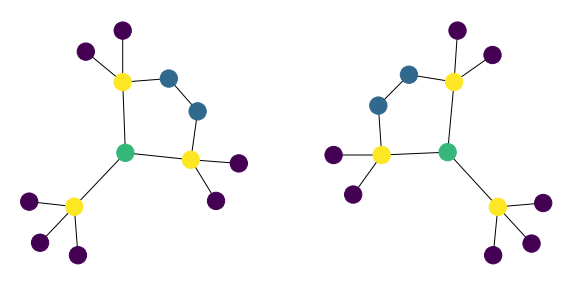

In [32]:
# draw a tree graph with 10 nodes
G = nx.balanced_tree(3, 2)

# add an edge between 4 and 11
G.add_edge(6, 11)


# calculate the spring layout for H
Gpos = torch.tensor(list(nx.spring_layout(G).values()))

# draw the graphs on two subfigures, side by side, colored by their respective node degrees
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
nx.draw(G, pos=Gpos, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

Gpos_rot = rot2(Gpos, np.pi/2)

plt.subplot(1, 2, 2)
nx.draw(G, pos=Gpos_rot, with_labels=False, font_weight='bold', node_color=list(dict(G.degree()).values()))

In [33]:
# a function for turning graph features into tensors
def tensorize(G, Z, H):
    """ 
    A function for extracting graph embedding data:
    Inputs: 
        G: an nx_graph
        Z: a torch tensor of equivariant features of size (m_0,n) 
                where m_0 is the number of nodes and n is the equivariant feature dimension
        H: a torch tensor of non-equivariant features of size (m_0,l) 
                where m_0 is the number of nodes and l is the feature dimension
        
    Outputs:
        Gdata: a dictionary containing the graph, the node positions, the one hot degree sequence, the chains, and the B matrix
    """

    # make a dictionary containing: the graph G, the node positions Gpos, and the one hot degree sequence, the chains
    Gdata = {'graph': G, 'Z': Z.float(), 'H': H.float(), 'Z_chains': nxgraph_to_chain(G, Z).float(), 'H_chains' : nxgraph_to_chain(G, H).float()}

    Gdata['dZ'] = (Gdata['Z_chains'][:,1,:] - Gdata['Z_chains'][:,0,:])
    Gdata['dH'] = (Gdata['H_chains'][:,1,:] - Gdata['H_chains'][:,0,:])

    Gdata['B'] = torch.cat((Gdata['Z'].T @ Gdata['H'], Gdata['dZ'].T @ Gdata['dH']), axis=1)

    return Gdata

In [34]:
# make
Gdata = tensorize(G,Z=Gpos,H=one_hot_degree_sequence)


## Integration

Now we prepare the code for integration of the edges in the graph against the vector field. We will use the trapezoidal rule for this.

In [35]:
# a function for turning a path into a chain
def graph_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = torch.tensor(graph['x'])

    # get edges
    edge_index =torch.tensor(data['edge_index']).T

    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

def path_to_chain(p):
    """  
    A function for turning a path into a chain

    Parameters
    ----------
    p : numpy array
        A path in R^n, represented as a numpy array of shape (p,n), where p is the number of points in the path

    Returns
    -------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.
        The middle index corresponds to start and endpoints of the edges in the chain.
    """

    r = len(p) - 1

    n = p[0].shape[0]
    
    
    chain = torch.zeros((r,2,n))

    chain[:,1,:] = torch.tensor(p[1:,:])
    chain[:,0,:] = torch.tensor(p[0:-1,:])

    return chain

    
# a function for turning a chain into a discretized chain
def discretize_chain(chain,d):
    """ 
    A function for turning a chain into a discretized chain

    Parameters
    ----------
    chain : numpy array
        A chain in R^n, represented as a numpy array of shape (p-1,2,n), where p is the number of points in the path.

    d : int
        The number of points in the discretized chain

    Returns
    -------
    d_chain : numpy array
        A discretized chain in R^n, represented as a numpy array of shape (p-1,d,n), where p is the number of points in the path.

    """

    r = chain.shape[0]

    n = chain.shape[2]

    d_chain = torch.zeros((r,d,n))

    t = np.linspace(0,1,d)

    for i in range(d):

        d_chain[:,i,:] = (1-t[i]) * chain[:,0,:] + t[i] * chain[:,1,:] 

    return d_chain


In [36]:
# create a forward pass
def Vfwd(X, model, base):
    """ 
    A function for performing a forward pass of the equivariant layer

    Inputs:
        X: a torch tensor of shape (batch, z)
        model: a torch sequential model
        base: a torch tensor of shape (z, h)
    
    Outputs:
        finalwrap: a torch tensor of shape (batch, z, num_vf)

    """

    # original shape of X
    orig_shape = X.shape

    # apply the model to the invariant summary
    out = model(X @ base)

    # calculate dim h
    dimh = base.shape[1] // 2

    # calculate num_vf
    nvf = int(out.shape[-1] / (1+2*dimh))    

    # add a dimension to X
    Y = X.unsqueeze(-1)

    # combine dimensions 1 and 2 of Y so that batch/edge and discrete steps are combined
    Y = Y.reshape(Y.shape[0]*Y.shape[1],Y.shape[2], Y.shape[3])


    bases = torch.stack([base] * Y.shape[0])

    # concat the bases along the batch dimension
    # these are the base vectors which generate the vector field
    full_bases = torch.cat((Y,bases),axis=-1)

    # reshape the output of the model
    out = out.view(-1, nvf, 1+2*dimh)

    # switch 1st and 2nd dimensions
    out = out.permute(0,2,1)

    # this is the output containing the vector field values of each batch
    final = torch.matmul(full_bases, out)

    return final

In [37]:
# a function for turning a chain into a cochain data matrix
def equi_integratrix(vf,chain, B, d = 5):
    """
    A function for generating an integratrix from a chain and a vector field

    Parameters
    ----------
    vf : a Pytorch Sequential object
        The vector field to be applied to the chain
    
    chain : a torch tensor of shape (r,2,n)
        The chain to be turned into a cochain data matrix

    B : a torch tensor of shape (z,h)
        The invariant summary matrix of the chain

    d : int
        The number of discrete steps in the discretization of the chain
    
    Returns
    -------
    out : a torch tensor of shape (r,c)
        The cochain data matrix
    """

    
    # discretize the chain
    chain = discretize_chain(chain, d)

    # number of simplicies
    r = chain.shape[0]

    # number of discrete steps
    d = chain.shape[1]

    # dimension of ambient space
    n = chain.shape[2]

    # number of feature-cochains in the cochain data matrix
    c = int(vf[-1].out_features)

    # apply the vector field to the discretized chain
    out = Vfwd(chain, vf, B).reshape((r,d,n,-1))

    # calculate the simplex gradients
    simplex_grad = chain[:,1,:] - chain[:,0,:]

    # swap dimensions n and c in out
    out = out.permute(0,1,3,2)

    # calculate the inner product of the vector field and the simplex gradients at each discrete step on each simplex
    inner_prod = torch.matmul(out,simplex_grad.T/(d-1))

    # take diagonal of out3 along axis 0 and 3 (this corresponds to correcting the broadcasted multplication effect)
    inner_prod = torch.diagonal(inner_prod, dim1 = 0, dim2 = 3)

    # permute dimensions 0 and 2 of out4
    inner_prod = inner_prod.permute(2,0,1)

    # apply the trapzoidal rule to the inner product
    cdm = (inner_prod[:,1:,:] + inner_prod[:,0:-1,:])/2
    cdm = cdm.sum(axis = 1)

    return cdm

### $O(n)$ Invariance of Integratrices

In theory, rotated/reflected copies of an embedded graph should produce the same integratix against our equivariant vector field. An important aspect is that the vector field does require the specific rotation of the graph to be known. Thus, if two graphs are related by an unknown rotation they will automatically produce the same integratrix without having to align them in any way. In summary, $O(n)$-equivariant vector fields produce $O(n)$-invariant integratrices, and do not require any alignment. We confirm this numerically below. 

In [38]:
# make a rotated version of G
Gdata_rot = tensorize(G,Z=rot2(Gpos,np.pi/2),H=one_hot_degree_sequence)

# calculate integratrices, note pi/2 is not an input
A = equi_integratrix(model, Gdata['Z_chains'], Gdata['B'])
B = equi_integratrix(model, Gdata_rot['Z_chains'], Gdata_rot['B'])

# compare the integratrices up to a small numerical error
A-B < 1e-8

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True]])

Looks good!

# Synthetic Example
## Graph Isomorphism Testing

In this synthetic example, we will embed two different isomorphic classes of graphs using the spring layout. Recomputing the spring layout for each graph will produce different embeddings which will be close to isometric with minor variations. 

In [39]:
# generate 10 different non-isomorphic graphs with the same nodes, edges and degree sequence
graphs = [nx.random_degree_sequence_graph([3,3,3,3,3,2,2,1,1,1], tries=100) for i in range(3)]

/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/collections.py:1419: ComplexWarning: Casting complex values to real discards the imaginary part
  else mpath.Path(np.asarray(seg, float))
/Users/maggs/miniconda3/envs/cochainrl/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


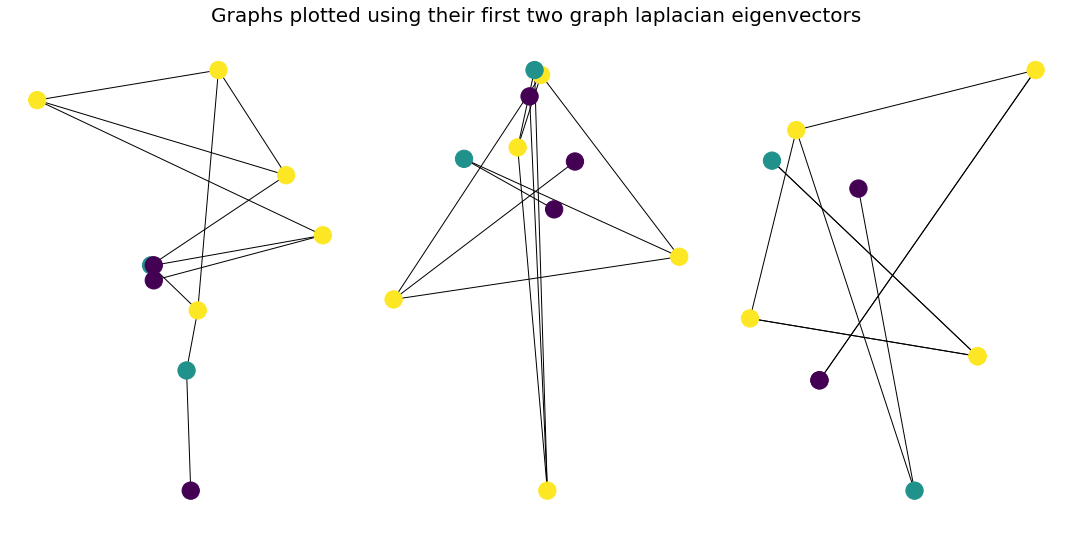

In [40]:
# calculate the first two graph laplacian eigenvectors
eigvecs = [torch.linalg.eig(torch.tensor(nx.laplacian_matrix(graph).todense()).float())[1][:,1:3] for graph in graphs]

# plot the graphs using their first two graph laplacian eigenvectors
plt.figure(figsize=(15,15))

for i in range(3):
    plt.subplot(2, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

# add title
plt.suptitle('Graphs plotted using their first two graph laplacian eigenvectors', fontsize=20)

# center the title
plt.tight_layout()

Almost looks like a Kandinsky painting!

### Learning Characteristic Vector Fields

The goal of this experiment is purely pedagogical. We wish to give the learning algorithm the objective of learning a vector field which is characteristic of the graph class. The idea is that each vector field should produce a large integratrix for its own graph and a small integratrix for the other graph.

In [41]:
# data transformation 

# one hot encode the degree sequence
one_hot_degree_sequence = torch.nn.functional.one_hot(torch.tensor([3,3,3,3,3,2,2,1,1,1])).float()

# tensorize the graphs with the laplacian eigenvectors as the equivariant features
# and the one hot degree sequence as the non-equivariant features
data = [tensorize(graphs[i], Z=eigvecs[i], H=one_hot_degree_sequence) for i in range(3)]

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/3333705.py:17: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:276.)
  Gdata = {'graph': G, 'Z': Z.float(), 'H': H.float(), 'Z_chains': nxgraph_to_chain(G, Z).float(), 'H_chains' : nxgraph_to_chain(G, H).float()}


In [42]:
dimH = 4
dimZ = 2
num_vf = 3

# generate a torch sequential neural network with two hidden layers
isomodel = nn.Sequential(nn.Linear(2*dimH, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, (1+2*dimH)*num_vf)
                      )

In [43]:
def simple_vf_plot2(model, base, ax, radius = 1, comp = 0):
    x = np.linspace(-radius,radius,20)
    y = np.linspace(-radius,radius,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor([inp]).float()


            tv = fwd(inp,model,base).detach().numpy()[0][:,comp]


            U[i,j] = tv[0]
            V[i,j] = tv[1]
    ax.quiver(X,Y,U,V)

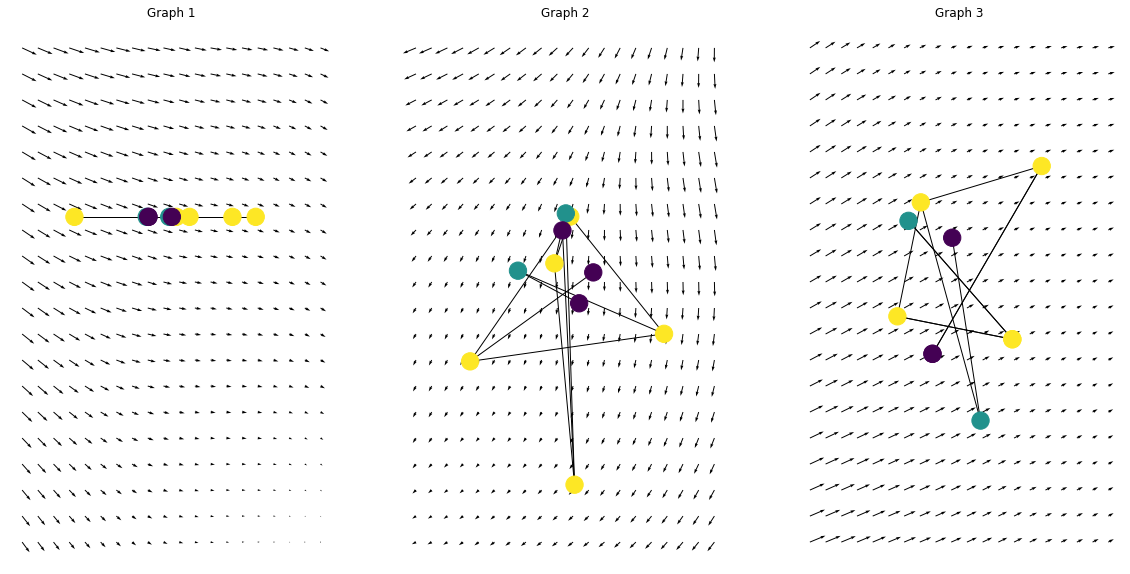

In [44]:
# plot the graphs and initialized vector fields
fig, ax = plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    simple_vf_plot2(isomodel, data[i]['B'], ax[i%5], comp=0)
    plt.subplot(1, 3, i+1)
    nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', node_color=list(dict(graphs[i].degree()).values()))

    # title the subplot with the angle in radians
    plt.title('Graph ' + str(i+1) )





In [45]:
labels = torch.tensor([0,1,2])

# intialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(isomodel.parameters(), lr=0.001)

In [46]:
# train the model
for epoch in range(20):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

    for i in range(3):

        X = outputs[i]

        #X = torch.sum(X, axis = 0)
        X = torch.diag(X.T @ X)

        # perform softmax on X
        X = torch.nn.functional.softmax(X)

        outputs[i] = X

    loss = sum([criterion(outputs[i], labels[i]) for i in range(3)])
    loss.backward()
    optimizer.step()

    
    # print statistics every 5 epochs
    if epoch % 5 == 0:    
        print('Epoch: ', epoch, 'Loss: ', loss.item())


    # print training accuracy 


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/4245759521.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


Epoch:  0 Loss:  3.290761709213257
Epoch:  5 Loss:  2.5505495071411133
Epoch:  10 Loss:  1.797566294670105
Epoch:  15 Loss:  1.682523488998413


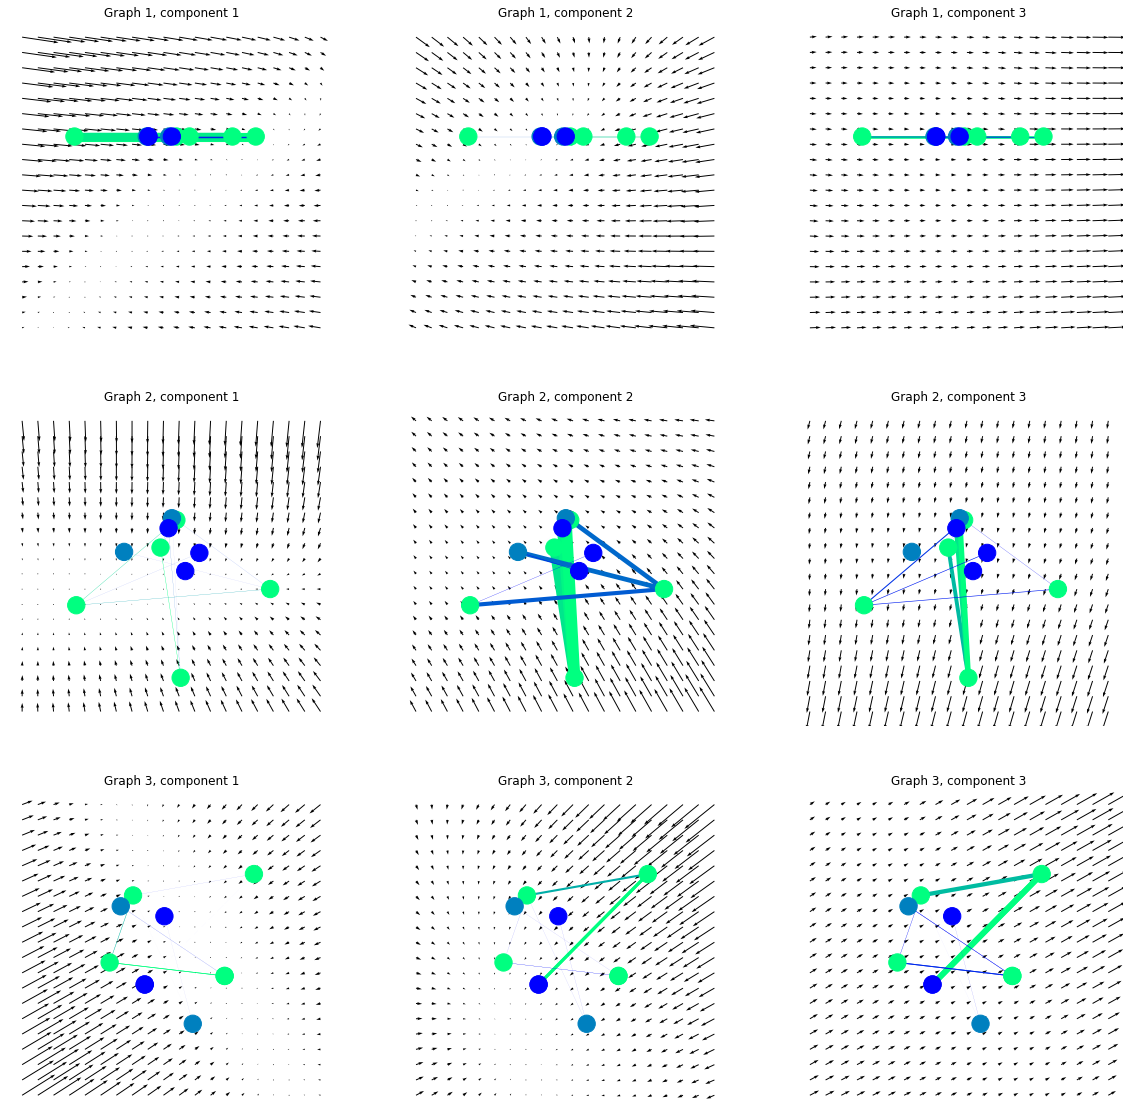

In [47]:
# make the same plot in a 3x3 iterating over the components of the vector field
fig, ax = plt.subplots(3,3,figsize=(20,20))

outputs = [(equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']))**2 for i in range(3)]

for i in range(3):
    for j in range(3):
        simple_vf_plot2(isomodel, data[i]['B'], ax[i,j], comp=j)
        plt.subplot(3, 3, 3*i+j+1)
        nx.draw(graphs[i], pos=eigvecs[i].detach().numpy(), with_labels=False, font_weight='bold', cmap = plt.cm.winter, node_color=list(dict(graphs[i].degree()).values()), edge_cmap = plt.cm.winter, edge_color = 5*outputs[i][:,j].detach().numpy(), width=2*outputs[i][:,j].detach().numpy())



        # title the subplot with the angle in radians
        plt.title('Graph ' + str(i+1) + ', component ' + str(j+1) )

# swap the subplots of the figure by a transposition
ax = ax.T

In [48]:
# calculate test accuracy
outputs = [equi_integratrix(isomodel, data[i]['Z_chains'], data[i]['B']) for i in range(3)]

for i in range(3):
    
        X = outputs[i]
    
        X = torch.diag(X.T @ X)
    
        # perform softmax on X
        X = torch.nn.functional.softmax(X)
    
        outputs[i] = X


# calculate test accuracy
correct = 0
total = 0

for i in range(3):
    total += 1
    if torch.argmax(outputs[i]) == labels[i]:
        correct += 1

print('Test Accuracy: ', correct/total)


Test Accuracy:  1.0


/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/4285167842.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = torch.nn.functional.softmax(X)


In [49]:
outputs = torch.stack(outputs)

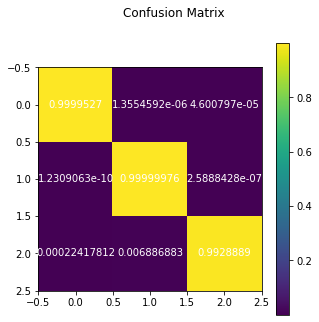

In [50]:
# plot outputs as a heatmap
plt.figure(figsize=(5,5))
plt.imshow(outputs.detach().numpy(), cmap='viridis' , interpolation='nearest')
plt.colorbar()

# add an argument to imshow to display the values of outputs
for i in range(3):
    for j in range(3):
        plt.text(j, i, outputs[i,j].detach().numpy(), ha="center", va="center", color="w")


# add a title confusion matrix
plt.suptitle("Confusion Matrix")

plt.show()


# Graph Classification Tasks

## COX2 Fully Worked Example





### Data pre-processing and plotting

In [51]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx, from_networkx

In [52]:
dataset = TUDataset(root='/tmp/COX2', name='COX2', use_node_attr=True)

Extracting /tmp/COX2/COX2/COX2.zip
Processing...
Done!


In [55]:
# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/1874507054.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z = torch.tensor(g['x'][:,:3])
/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/1874507054.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(g['x'][:,3:])


In [56]:
import plotly.graph_objects as go

In [57]:
# turn the above example into a function

def plot_molecule(tensorized):
    """ 
    A function for plotting a molecule

    Parameters
    ----------
    tensorized : a dictionary containing the graph, the node positions, the one hot degree sequence, the chains, and the B matrix
    
    Returns
    -------
    fig : a plotly figure
        A plotly figure containing the plot of the molecule
    """

    # invert one hot encoding of tensorized['H']
    H = torch.argmax(tensorized['H'],axis=1)

    fig = go.Figure(data=[go.Scatter3d(x=tensorized['Z'][:,0], y=tensorized['Z'][:,1], z=tensorized['Z'][:,2],
                                      mode='markers', marker=dict(size=7, color=H, colorscale='Viridis', opacity=0.8),showlegend=False)])

    for i in range(tensorized['Z_chains'].shape[0]):
        fig.add_trace(go.Scatter3d(x=[tensorized['Z_chains'][i,0,0], tensorized['Z_chains'][i,1,0]],
                                   y=[tensorized['Z_chains'][i,0,1], tensorized['Z_chains'][i,1,1]],
                                   z=[tensorized['Z_chains'][i,0,2], tensorized['Z_chains'][i,1,2]],
                                   mode='lines',
                                   showlegend=False,))
        
    # make it square and zoom to fit
    fig.update_layout(width=600, height=500, autosize=False, margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(scene_aspectmode='cube')

    
    
    return fig

# plot the molecule
fig = plot_molecule(tdata[3])

fig.show()


### Learning

In [58]:
class EVfModel(torch.nn.Module):
    def __init__(
        self,
        dimH,
        num_classes = 2,
        num_vf = 5,
        evf_hidden_dim= 32,
        classifier_hidden_dim=16
    ):
    
        super().__init__()

        self.evf = nn.Sequential(nn.Linear(2*dimH, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, (1+2*dimH)*num_vf)
                      )

        self.classifier = nn.Sequential(nn.Linear(num_vf, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, num_classes)
                      )
        
    def forward(self, tnsrdata):

        # calculate the invariant summary integratrix
        X = equi_integratrix(self.evf, tnsrdata['Z_chains'], tnsrdata['B'])

        # L2 readout layer
        X = torch.diag(X.T @ X)

        # apply the classifier to the output of the vector field
        pred = self.classifier(X)

        # apply softmax to the output of the classifier
        pred = nn.functional.log_softmax(pred, -1)

        return pred


In [59]:
# create a model
model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 32, classifier_hidden_dim=16)


In [60]:
# initialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()

# build an optimizer on evf and classifer parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# plot number of parameters in model
print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

# store labels
labels = dataset.y

Number of Parameters:  16 k


Epoch:  0 Loss:  1.7569112765917367
Training Accuracy:  0.6616702355460385 

Epoch:  1 Loss:  0.6057327942386433
Training Accuracy:  0.7430406852248393 

Epoch:  2 Loss:  0.505224352079628
Training Accuracy:  0.7665952890792291 

Epoch:  3 Loss:  0.44789308971007924
Training Accuracy:  0.7922912205567452 

Epoch:  4 Loss:  0.4239745653616813
Training Accuracy:  0.7965738758029979 

Epoch:  5 Loss:  0.3998113535547029
Training Accuracy:  0.815845824411135 

Epoch:  6 Loss:  0.3737425150209661
Training Accuracy:  0.815845824411135 

Epoch:  7 Loss:  0.3688960812188915
Training Accuracy:  0.8351177730192719 

Epoch:  8 Loss:  0.36198727694973126
Training Accuracy:  0.8308351177730193 

Epoch:  9 Loss:  0.3354665668994164
Training Accuracy:  0.841541755888651 

Epoch:  10 Loss:  0.32864699076873216
Training Accuracy:  0.8458244111349036 

Epoch:  11 Loss:  0.3231235716823105
Training Accuracy:  0.841541755888651 

Epoch:  12 Loss:  0.4081615949737781
Training Accuracy:  0.828693790149893 


Text(0.5, 1.0, 'Training Accuracy')

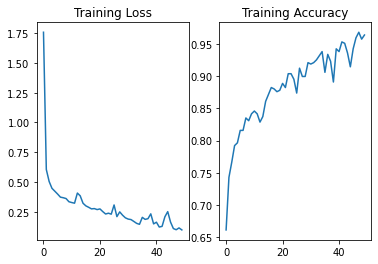

In [61]:
# train the model

all_loses = []
all_accuracies = []

for epoch in range(50):  # loop over the dataset multiple times

    # store epoch loss
    epoch_loss = 0

    # print training accuracy 
    correct = 0
    total = 0

    # forward + backward + optimize
    for i in range(len(tdata)):

        pred = model(tdata[i])
        
        if torch.argmax(pred) == labels[i]:
            correct += 1

        total += 1

        loss = criterion(pred, labels[i])

        loss.backward() 

        optimizer.step()

        epoch_loss += loss.item()


        # zero the parameter gradients
        optimizer.zero_grad()


    #print total loss over the epoch
    print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
    print('Training Accuracy: ', correct/total, "\n")

    all_loses.append(epoch_loss/len(tdata))
    all_accuracies.append(correct/total)


print('Finished Training')

# initialise 2 subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
ax1.plot(all_loses)
# add title
ax1.set_title('Training Loss')

# plot accuracy
ax2.plot(all_accuracies)
# add title
ax2.set_title('Training Accuracy')


# Generalisation of Testing Framework

In [62]:
dataset = TUDataset(root='/tmp/COX2', name='COX2', use_node_attr=True)

# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/1562974530.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_6144/1562974530.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [63]:
class EVfModel2(torch.nn.Module):
    def __init__(
        self,
        dimH,
        num_classes = 2,
        num_vf = 5,
        evf_hidden_dim= 32,
        classifier_hidden_dim=16
    ):
    
        super().__init__()

        self.evf = nn.Sequential(nn.Linear(2*dimH, evf_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, evf_hidden_dim), 
                      nn.LeakyReLU(),
                      nn.Linear(evf_hidden_dim, (1+2*dimH)*num_vf)
                      )

        self.classifier = nn.Sequential(nn.Linear(num_vf, classifier_hidden_dim), 
                      nn.LeakyReLU(), 
                      nn.Linear(classifier_hidden_dim, classifier_hidden_dim),
                      nn.LeakyReLU(),
                      nn.Linear(classifier_hidden_dim, num_classes)
                      )
        
    def forward(self, tnsrdata):

        # calculate the invariant summary integratrix
        X = equi_integratrix(self.evf, tnsrdata['Z_chains'], tnsrdata['B'])

        # L2 readout layer
        X = torch.diag(X.T @ X)

        # apply the classifier to the output of the vector field
        pred = self.classifier(X)

        # apply softmax to the output of the classifier
        pred = nn.functional.log_softmax(pred, -1)

        return pred


In [90]:
# construct evf model
model = EVfModel2(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 64, classifier_hidden_dim=16)

# initialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()

# build an optimizer on evf and classifer parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# plot number of parameters in model
print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")


Number of Parameters:  50 k


In [91]:
from numpy import random

# shuffle the data
random.shuffle(tdata)

# train/test split for tdata
train_tdata = tdata[:int(len(tdata)*0.8)]
test_tdata = tdata[int(len(tdata)*0.8):]

# train/test split for labels
train_labels = dataset.y[:int(len(dataset)*0.8)]
test_labels = dataset.y[int(len(dataset)*0.8):]

Epoch:  0 Loss:  6.938044438921492
Training Accuracy:  0.5711920529801324 

Epoch:  1 Loss:  0.9099783347064917
Training Accuracy:  0.6142384105960265 

Epoch:  2 Loss:  0.9166832547793686
Training Accuracy:  0.652317880794702 

Epoch:  3 Loss:  0.5257404285026702
Training Accuracy:  0.6937086092715232 

Epoch:  4 Loss:  0.6289342497911666
Training Accuracy:  0.6903973509933775 

Epoch:  5 Loss:  0.6553897989531376
Training Accuracy:  0.6887417218543046 

Epoch:  6 Loss:  0.6111118917486867
Training Accuracy:  0.706953642384106 

Epoch:  7 Loss:  1.1151110871960044
Training Accuracy:  0.6738410596026491 

Epoch:  8 Loss:  1.4337419125985125
Training Accuracy:  0.6738410596026491 

Epoch:  9 Loss:  0.48311633271200893
Training Accuracy:  0.7019867549668874 

Epoch:  10 Loss:  0.4931007124315699
Training Accuracy:  0.706953642384106 

Epoch:  11 Loss:  0.43974099628782176
Training Accuracy:  0.7251655629139073 

Epoch:  12 Loss:  0.4535396462170529
Training Accuracy:  0.7350993377483444 

Text(0.5, 1.0, 'Training Accuracy')

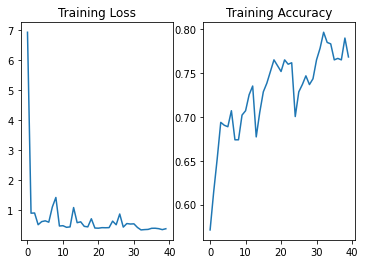

In [92]:
epochs = 40

# store training loss and accuracy
all_loses = []
all_accuracies = []

batch_size = 5

for epoch in range(epochs):  # loop over the dataset multiple times

    # store epoch loss
    epoch_loss = 0

    # print training accuracy
    correct = 0
    total = 0

    # shuffle the training data
    random.shuffle(train_tdata)

    # iterate through the training data batch by batch

    for i in range(0, len(train_tdata), batch_size):

        # create a batch of training data
        batch = train_tdata[i:i+batch_size]


        for j in range(len(batch)):
            pred = model(batch[j])


            if torch.argmax(pred) == batch[j]['y']:
                correct += 1

            total += 1

            loss = criterion(pred, batch[j]['y'])

            loss.backward() 

            optimizer.step()

            epoch_loss += loss.item()

            # zero the parameter gradients
            optimizer.zero_grad()

    #print total loss over the epoch
    print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
    print('Training Accuracy: ', correct/total, "\n")

    all_loses.append(epoch_loss/len(tdata))
    all_accuracies.append(correct/total)


print('Finished Training')

# initialise 2 subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
ax1.plot(all_loses)
# add title
ax1.set_title('Training Loss')

# plot accuracy
ax2.plot(all_accuracies)
# add title
ax2.set_title('Training Accuracy')




In [93]:
# evaluate the model on the test data

# print test accuracy
correct = 0

for i in range(len(test_tdata)):
    pred = model(test_tdata[i])

    if torch.argmax(pred) == test_tdata[i]['y']:
        correct += 1

print('Test Accuracy: ', correct/len(test_tdata))

Test Accuracy:  0.7368421052631579


### DHFR



In [74]:
dataset = TUDataset(root='/tmp/DHFR', name='DHFR', use_node_attr=True)

# convert the dataset to tensorized format
tdata = []
for data in dataset:
    g = data
    G = to_networkx(g)
    Z = torch.tensor(g['x'][:,:3])
    H = torch.tensor(g['x'][:,3:])
    Gdata = tensorize(G,Z,H)
    tdata.append(Gdata)
    Gdata['y'] = data['y'][0]

Extracting /tmp/DHFR/DHFR/DHFR.zip
Processing...
Done!
/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_7024/9450950.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_7024/9450950.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [75]:
# plot the molecule
fig = plot_molecule(tdata[0])

fig.show()

In [76]:
# construct evf model
model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 32, classifier_hidden_dim=16)

# initialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()

# build an optimizer on evf and classifer parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# plot number of parameters in model
print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")


Number of Parameters:  23 k


In [273]:
# train/test split for tdata
train_tdata = tdata[:int(len(tdata)*0.8)]
test_tdata = tdata[int(len(tdata)*0.8):]

# train/test split for labels
train_labels = dataset.y[:int(len(dataset)*0.8)]
test_labels = dataset.y[int(len(dataset)*0.8):]

Epoch:  0 Loss:  0.44158436475853097
Training Accuracy:  0.7417218543046358 

Epoch:  1 Loss:  0.41621367592119723
Training Accuracy:  0.7400662251655629 

Epoch:  2 Loss:  0.41647263227114595
Training Accuracy:  0.7384105960264901 

Epoch:  3 Loss:  0.38975529012057897
Training Accuracy:  0.75 

Epoch:  4 Loss:  0.39934716483741506
Training Accuracy:  0.7384105960264901 

Epoch:  5 Loss:  0.4250859449487277
Training Accuracy:  0.7350993377483444 

Epoch:  6 Loss:  0.395683791208382
Training Accuracy:  0.7417218543046358 

Epoch:  7 Loss:  0.3848351626116651
Training Accuracy:  0.7582781456953642 

Epoch:  8 Loss:  0.3800073659700646
Training Accuracy:  0.7516556291390728 

Epoch:  9 Loss:  0.3694562720080393
Training Accuracy:  0.7665562913907285 

Epoch:  10 Loss:  0.4602043308955872
Training Accuracy:  0.7450331125827815 

Epoch:  11 Loss:  0.48739421606700284
Training Accuracy:  0.75 

Epoch:  12 Loss:  0.43317448496893435
Training Accuracy:  0.7483443708609272 

Epoch:  13 Loss:  

Text(0.5, 1.0, 'Training Accuracy')

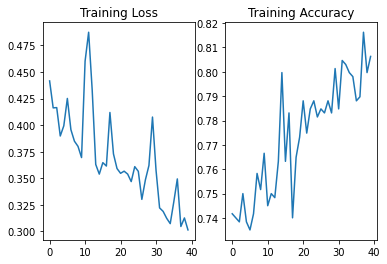

In [275]:
epochs = 40

# store training loss and accuracy
all_loses = []
all_accuracies = []

batch_size = 5

for epoch in range(epochs):  # loop over the dataset multiple times

    # store epoch loss
    epoch_loss = 0

    # print training accuracy
    correct = 0
    total = 0

    # shuffle the training data
    random.shuffle(train_tdata)

    # iterate through the training data batch by batch

    for i in range(0, len(train_tdata), batch_size):

        # create a batch of training data
        batch = train_tdata[i:i+batch_size]


        for j in range(len(batch)):
            pred = model(batch[j])


            if torch.argmax(pred) == batch[j]['y']:
                correct += 1

            total += 1

            loss = criterion(pred, batch[j]['y'])

            loss.backward() 

            optimizer.step()

            epoch_loss += loss.item()

            # zero the parameter gradients
            optimizer.zero_grad()

    #print total loss over the epoch
    print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
    print('Training Accuracy: ', correct/total, "\n")

    all_loses.append(epoch_loss/len(tdata))
    all_accuracies.append(correct/total)


print('Finished Training')

# initialise 2 subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
ax1.plot(all_loses)
# add title
ax1.set_title('Training Loss')

# plot accuracy
ax2.plot(all_accuracies)
# add title
ax2.set_title('Training Accuracy')

In [64]:
# generalise the above into a single train function
def train_model(model, criterion, optimizer, tdata, epochs=40, batch_size=5):

    # train/test split for tdata
    train_tdata = tdata[:int(len(tdata)*0.8)]
    test_tdata = tdata[int(len(tdata)*0.8):]

    # store training loss and accuracy
    all_loses = []
    all_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        # store epoch loss
        epoch_loss = 0

        # print training accuracy
        correct = 0
        total = 0

        # shuffle the training data
        random.shuffle(train_tdata)

        # iterate through the training data batch by batch

        for i in range(0, len(train_tdata), batch_size):

            # create a batch of training data
            batch = train_tdata[i:i+batch_size]


            for j in range(len(batch)):
                pred = model(batch[j])


                if torch.argmax(pred) == batch[j]['y']:
                    correct += 1

                total += 1

                loss = criterion(pred, batch[j]['y'])

                loss.backward() 

                optimizer.step()

                epoch_loss += loss.item()

                # zero the parameter gradients
                optimizer.zero_grad()

        #print total loss over the epoch
        print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
        print('Training Accuracy: ', correct/total, "\n")

        all_loses.append(epoch_loss/len(tdata))
        all_accuracies.append(correct/total)


    print('Finished Training')

    # initialise 2 subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plot loss
    ax1.plot(all_loses)
    # add title
    ax1.set_title('Training Loss')

    # plot accuracy
    ax2.plot(all_accuracies)
    # add title
    ax2.set_title('Training Accuracy')

    # print test accuracy
    correct = 0

    for i in range(len(test_tdata)):
        pred = model(test_tdata[i])

        if torch.argmax(pred) == test_tdata[i]['y']:
            correct += 1

    print('Test Accuracy: ', correct/len(test_tdata))

    return model, all_loses, all_accuracies, correct/len(test_tdata)

Number of Parameters:  50 k
Epoch:  0 Loss:  2.324511259446064
Training Accuracy:  0.5115894039735099 

Epoch:  1 Loss:  2.2557539690565966
Training Accuracy:  0.5496688741721855 

Epoch:  2 Loss:  0.9584981472305711
Training Accuracy:  0.5927152317880795 

Epoch:  3 Loss:  1.1580022984345322
Training Accuracy:  0.5562913907284768 

Epoch:  4 Loss:  1.3835265163888835
Training Accuracy:  0.5645695364238411 

Epoch:  5 Loss:  1.1574322407290205
Training Accuracy:  0.5496688741721855 

Epoch:  6 Loss:  0.9432923332947161
Training Accuracy:  0.5761589403973509 

Epoch:  7 Loss:  0.7727298749545745
Training Accuracy:  0.5745033112582781 

Epoch:  8 Loss:  0.7271168360628681
Training Accuracy:  0.6009933774834437 

Epoch:  9 Loss:  0.7092240666888417
Training Accuracy:  0.5844370860927153 

Finished Training
Test Accuracy:  0.75


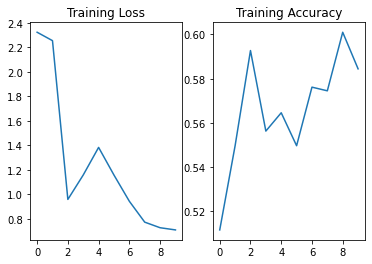

In [80]:
# construct evf model
model = EVfModel(dimH = tdata[0]['H'].shape[1], num_classes = 2, num_vf = 5, evf_hidden_dim= 32, classifier_hidden_dim=16)

# initialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()

# build an optimizer on evf and classifer parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# plot number of parameters in model
print("Number of Parameters: ", sum(p.numel() for p in model.parameters())//1000, "k")

# train the model
model, all_loses, all_accuracies, test_accuracy = train_model(model, criterion, optimizer, tdata, epochs=1, batch_size=5)

In [165]:
# import baseline models using pytorch geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv

# construct a GCN model
class GCN(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16, num_layers = 4):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.convstart = GCNConv(dimH, self.hidden_dim)
        for i in range(self.num_layers-2):
            self.add_module('conv{}'.format(i+2), GCNConv(self.hidden_dim, self.hidden_dim))
        self.convend = GCNConv(self.hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.convstart(x, edge_index).relu()
        for i in range(self.num_layers-2):
            x = self._modules['conv{}'.format(i+2)](x, edge_index).relu()
        x = self.convend(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)
    

        return x
    
# construct a GAT model 
class GAT(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16, num_layers = 4):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.convstart = GATConv(dimH, self.hidden_dim, heads=8, dropout=0.6)
        for i in range(num_layers-2):
            self.add_module('conv{}'.format(i+2), GATConv(self.hidden_dim * 8, self.hidden_dim, heads=8, dropout=0.6))

        self.convend = GATConv(16 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.convstart(x, edge_index).relu()
        for i in range(self.num_layers-2):
            x = self._modules['conv{}'.format(i+2)](x, edge_index).relu()
        x = self.convend(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)

        return x
    
# construct a SAGE model
class SAGE(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16):
        super().__init__()

        self.conv1 = SAGEConv(dimH, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index)

        x = torch.sum(x,axis=0)
        x = nn.functional.log_softmax(x, -1)

        return x
    
# construct a GIN model
class GIN(torch.nn.Module):
    def __init__(self, dimH, num_classes = 2, hidden_dim = 16):
        super().__init__()

        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(dimH, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        ))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)

        x = torch.sum(x,axis=0)

        x = nn.functional.log_softmax(x, -1)

        return x
    



In [166]:
dataset[0].x.shape[1]


56

In [169]:
dataset[0]

# forward pass of the GCN model
GCN_model = GCN(dimH = dataset[0].x.shape[1], num_classes = 2, hidden_dim = 128, num_layers = 5)

# print number of model parameters
print("Number of Parameters: ", sum(p.numel() for p in GCN_model.parameters())//1000, "k")

# forward pass of the GAT model
GAT_model = GAT(dimH = dataset[0].x.shape[1])
GAT_output = GAT_model(dataset[0])
# print number of model parameters
print("Number of Parameters: ", sum(p.numel() for p in GAT_model.parameters())//1000, "k")
print("GAT output: ", GAT_output)

# forward pass of the SAGE model
SAGE_model = SAGE(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=100)
SAGE_output = SAGE_model(dataset[0])
print("Number of Parameters: ", sum(p.numel() for p in SAGE_model.parameters())//1000, "k")
print("SAGE output: ", SAGE_output)

# forward pass of the GIN model
GIN_model = GIN(dimH = dataset[0].x.shape[1], num_classes=2, hidden_dim=128)
GIN_output = GIN_model(dataset[0])
# print number of model parameters
print("Number of Parameters: ", sum(p.numel() for p in GIN_model.parameters())//1000, "k")

print( "GIN output: ", GIN_output)

Number of Parameters:  57 k
GCN output:  tensor([-4.4881, -0.0113], grad_fn=<LogSoftmaxBackward0>)
Number of Parameters:  41 k
GAT output:  tensor([-0.5459, -0.8659], grad_fn=<LogSoftmaxBackward0>)
Number of Parameters:  51 k
SAGE output:  tensor([-1.1435, -0.3837], grad_fn=<LogSoftmaxBackward0>)
Number of Parameters:  57 k
GIN output:  tensor([-26.2995,   0.0000], grad_fn=<LogSoftmaxBackward0>)


In [170]:
# train the GCN model
GCN_model, GCN_loses, GCN_accuracies, GCN_test_accuracy = train_model(GCN_model, criterion, optimizer, dataset, epochs=40, batch_size=5)

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_7024/3860869279.py:22: UserWarning:

you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.



TypeError: 'TUDataset' object does not support item assignment

In [187]:
# generalise the above into a single train function
def baseline_train_model(model, criterion, optimizer, dataset, epochs=40, batch_size=5):

    # create a random permutation of len(dataset)
    random_perm = np.random.permutation(len(dataset))

    # permute the dataset
    dataset = dataset[random_perm]

    # train/test split for tdata
    train_tdata = dataset[:int(len(tdata)*0.8)]
    test_tdata = dataset[int(len(tdata)*0.8):]

    # store training loss and accuracy
    all_loses = []
    all_accuracies = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        # store epoch loss
        epoch_loss = 0

        # print training accuracy
        correct = 0
        total = 0

        # shuffle the training data
         # create a random permutation of len(dataset)
        random_perm = np.random.permutation(len(train_tdata))
        train_tdata = train_tdata[random_perm]


        # iterate through the training data batch by batch

        for i in range(0, len(train_tdata), batch_size):

            # create a batch of training data
            batch = train_tdata[i:i+batch_size]


            for j in range(len(batch)):

                pred = model(batch[j])




                if torch.argmax(pred) == batch[j].y[0]:
                    correct += 1

                total += 1

                loss = criterion(pred, batch[j].y[0])

                loss.backward() 

                optimizer.step()

                epoch_loss += loss.item()

                # zero the parameter gradients
                optimizer.zero_grad()

        #print total loss over the epoch
        print('Epoch: ', epoch, 'Loss: ', epoch_loss/len(tdata))
        print('Training Accuracy: ', correct/total, "\n")

        all_loses.append(epoch_loss/len(tdata))
        all_accuracies.append(correct/total)


    print('Finished Training')

    # initialise 2 subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # plot loss
    ax1.plot(all_loses)
    # add title
    ax1.set_title('Training Loss')

    # plot accuracy
    ax2.plot(all_accuracies)
    # add title
    ax2.set_title('Training Accuracy')

    # print test accuracy
    correct = 0

    for i in range(len(test_tdata)):
        pred = model(test_tdata[i])

        if torch.argmax(pred) == test_tdata[i]['y']:
            correct += 1

    print('Test Accuracy: ', correct/len(test_tdata))

    return model, all_loses, all_accuracies, correct/len(test_tdata)

In [207]:
# remove first 3 columns from x for every graph in dataset
# copy dataset
dataset2 = dataset.copy()

for i in range(len(dataset)):
    dataset2[i].x = dataset[i].x[:,3:]

In [215]:


# make a new TU dataset with position features
dataset = TUDataset(root='/tmp/DHFR', name='DHFR', use_node_attr=False)



In [1]:
GCN_model = GCN(dimH = dataset[0].x.shape[1], num_classes = 2, hidden_dim = 128, num_layers = 5)

# print number of model parameters
print("Number of Parameters: ", sum(p.numel() for p in GCN_model.parameters())//1000, "k")


# initialise cross-entropy loss and adam optimizer
criterion = nn.CrossEntropyLoss()

# build an optimizer on evf and classifer parameters
optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.0001)


NameError: name 'GCN' is not defined

Epoch:  0 Loss:  0.5740932843120641
Training Accuracy:  0.5562913907284768 

Epoch:  1 Loss:  0.552598719795545
Training Accuracy:  0.5596026490066225 

Epoch:  2 Loss:  0.5477881938140229
Training Accuracy:  0.5761589403973509 

Epoch:  3 Loss:  0.539568468593258
Training Accuracy:  0.5960264900662252 

Epoch:  4 Loss:  0.5321720406294815
Training Accuracy:  0.6192052980132451 

Epoch:  5 Loss:  0.5253290070821999
Training Accuracy:  0.6341059602649006 

Epoch:  6 Loss:  0.518234427663542
Training Accuracy:  0.6175496688741722 

Epoch:  7 Loss:  0.5155249300200946
Training Accuracy:  0.6324503311258278 

Epoch:  8 Loss:  0.5017799939368925
Training Accuracy:  0.6556291390728477 

Epoch:  9 Loss:  0.49690403291590945
Training Accuracy:  0.6490066225165563 

Epoch:  10 Loss:  0.4870903240368953
Training Accuracy:  0.6622516556291391 

Epoch:  11 Loss:  0.4853956904656515
Training Accuracy:  0.6804635761589404 

Epoch:  12 Loss:  0.4798857317202621
Training Accuracy:  0.6688741721854304 

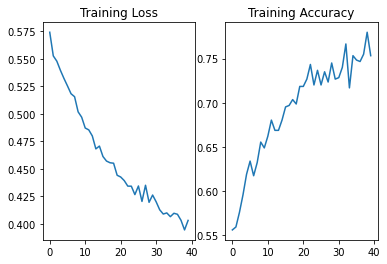

In [217]:
GCN_model, GCN_loses, GCN_accuracies, GCN_test_accuracy = baseline_train_model(GCN_model, criterion, optimizer, dataset, epochs=100, batch_size=5)

In [196]:
dataset[0].x

tensor([[-6.2964, -3.4575,  0.5722,  ...,  0.0000,  0.0000,  0.0000],
        [-5.9157, -4.6796,  0.9366,  ...,  0.0000,  0.0000,  0.0000],
        [-4.6528, -5.0636,  1.0928,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 5.9058,  6.5531, -2.2954,  ...,  0.0000,  0.0000,  0.0000],
        [ 7.5709,  4.7613, -1.8623,  ...,  0.0000,  0.0000,  0.0000],
        [ 6.9084,  2.7236, -0.6144,  ...,  0.0000,  0.0000,  0.0000]])

In [178]:
dataset[0].y

tensor([1])

# QM9

## Molecules in 3D


In [ ]:
import dgl

data = dgl.data.QM9Dataset(label_keys=['mu', 'alpha', 'homo', 'lumo'])

In [ ]:
# find max entry in Z for all graphs in data

max = 0
for graph in data:

    if torch.max(graph[0].ndata['Z']) > max:
        max = torch.max(graph[0].ndata['Z'])

print(max)

KeyboardInterrupt: 

In [ ]:
# plot a nx graph using the edges in graph.edges['uv'] and pos for positions
# a function for turning a path into a chain
def dgl_to_chain(graph):
    """ 
    A function for turning a graph into a chain
    """

    # get node features
    node_features = graph.ndata['R']

    # get edges
    u = graph.edges('uv')[0]
    v = graph.edges('uv')[1]
    edge_index = torch.stack((u,v)).T


    # number of 1-simplices
    r = edge_index.shape[0]

    # embedding dimension
    n = node_features.shape[1]

    # sort the edge indices
    edges = torch.tensor([np.sort([edge_index[i][0],edge_index[i][1]]) for i in range(len(edge_index))])

    # initialize chain
    ch = torch.zeros((r,2,n))

    # turn edges into a 1-chain
    for i in range(r):
        ch[i,0,:] = node_features[edges[i][0]]
        ch[i,1,:] = node_features[edges[i][1]]

    return ch

In [ ]:
def plot_chain3d(chain, ax, dgraph= None, c = None):

    for i in range(chain.shape[0]):
        ax.plot(chain[i,:,0],chain[i,:,1], chain[i,:,2], c = 'black')
        # plot nodes
        
    if dgraph != None:
        
        # convert node features to numpy array

        
        for i in range(len(dgraph.ndata['Z'])):
            ax.scatter(dgraph.ndata['R'][i,0],dgraph.ndata['R'][i,1])



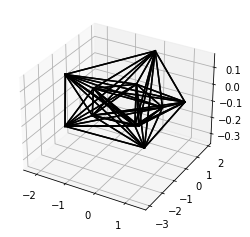

In [ ]:
# plot 3d graph
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

graph = data[200][0]

chain = dgl_to_chain(graph)

plot_chain3d(chain,ax)
plt.show()



In [ ]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])

# add in the edges to the plot
for i in range(graph.edges('uv')[0].shape[0]):
    fig.add_trace(go.Scatter3d(
        x=[graph.ndata['R'][graph.edges('uv')[0][i]][0],graph.ndata['R'][graph.edges('uv')[1][i]][0]],
        y=[graph.ndata['R'][graph.edges('uv')[0][i]][1],graph.ndata['R'][graph.edges('uv')[1][i]][1]],
        z=[graph.ndata['R'][graph.edges('uv')[0][i]][2],graph.ndata['R'][graph.edges('uv')[1][i]][2]],
        mode='lines',
        line=dict(
            color='black',
            width=2,
        )
    ))




# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [ ]:
R = graph.ndata['R']

AttributeError: 'tuple' object has no attribute 'ndata'

In [ ]:
Z = graph.ndata['Z']

AttributeError: 'tuple' object has no attribute 'ndata'

In [271]:
# testing


In [ ]:
# one hot encode Z
Z_oh = torch.nn.functional.one_hot(Z)

Z.shape

torch.Size([11])

In [ ]:
Z_oh = Z_oh.float()

In [ ]:
# normalize non-zero columns of z_oh
Z_oh = Z_oh / Z_oh.sum(axis = 0)

# replaces nan values with 0
Z_oh = torch.nan_to_num(Z_oh)

Z_oh

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [ ]:
R.shape


torch.Size([11, 3])

In [ ]:
base = R.T @ Z_oh

In [ ]:
base = base[:,[1,6,7]]

In [ ]:
Z

tensor([7, 6, 6, 7, 6, 7, 1, 1, 1, 1, 1])

In [ ]:
# plot the non-trivial columns of base in 3d using plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
)])

# tight layou
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()


In [ ]:
# use plotly to plot the 3d graph
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=graph.ndata['R'][:,0],
    y=graph.ndata['R'][:,1],
    z=graph.ndata['R'][:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=graph.ndata['Z'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1
    )
)])


fig.add_trace(go.Scatter3d(
    x=base[0,:],
    y=base[1,:],
    z=base[2,:],
    mode='markers',
    marker=dict(
        size=20,
        color=[1,6,7],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        symbol = 'square'
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color=[1],
        colorscale='Viridis',
        width=6,
    )
))

fig.add_trace(go.Scatter3d(
    x=[0,base[0,1]],
    y=[0,base[1,1]],
    z=[0,base[2,1]],
    mode='lines',
    line=dict(
        color=[6],
        colorscale='Viridis',
        width=6,
    )
))
fig.add_trace(go.Scatter3d(
    x=[0,base[0,2]],
    y=[0,base[1,2]],
    z=[0,base[2,2]],
    mode='lines',
    line=dict(
        color=[7],
        colorscale='Viridis',
        width=6,
    )
))

# supress trace information
fig.update_traces(showlegend=False)




# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()



In [ ]:
# plot vectors from the origin to each column of base
fig = go.Figure(data=[go.Scatter3d(
    x=[0,base[0,0]],
    y=[0,base[1,0]],
    z=[0,base[2,0]],
    mode='lines',
    line=dict(
        color='red',
        width=6,
    )
)])

fig.add_trace(go.Scatter3d(

In [ ]:
# calculate the cross product of the first two columns of base
cross = torch.cross(base[:,0],base[:,1])
